In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
eurusd = pd.read_csv('/kaggle/input/forex/EURUSD-60-DS.csv')

# دیتافریم‌های جدید
audusd = pd.read_csv('/kaggle/input/forex/AUDUSD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
gbpusd = pd.read_csv('/kaggle/input/forex/GBPUSD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
usdcad = pd.read_csv('/kaggle/input/forex/USDCAD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

for df in [eurusd, audusd, gbpusd, usdcad]:
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')

# تنظیم Date به‌عنوان ایندکس
eurusd.set_index('Date', inplace=True)
audusd.set_index('Date', inplace=True)
gbpusd.set_index('Date', inplace=True)
usdcad.set_index('Date', inplace=True)

eurusd = eurusd.add_prefix('EURUSD_')
audusd = audusd.add_prefix('AUDUSD_')
gbpusd = gbpusd.add_prefix('GBPUSD_')
usdcad = usdcad.add_prefix('USDCAD_')
df = eurusd.join([audusd, gbpusd, usdcad], how='inner')


In [3]:
close_columns = ['EURUSD_Open','EURUSD_High','EURUSD_Low','EURUSD_Close', 'AUDUSD_Close', 'GBPUSD_Close', 'USDCAD_Close']
data = df[close_columns].values

In [4]:

# نرمال‌سازی داده‌ها
scalers = {}
for i, col in enumerate(close_columns):
    scaler = MinMaxScaler()
    data[:, i] = scaler.fit_transform(data[:, i].reshape(-1, 1)).flatten()
    scalers[col] = scaler

scaled_data = data
n_features = len(close_columns) 
# تنظیمات
seq_length = 128  # تعداد ساعات گذشته برای ورودی
pred_length = 12  # تعداد ساعات آینده برای پیش‌بینی

# ساخت سکانس‌ها
X, y = [], []
for i in range(seq_length, len(scaled_data) - pred_length):
    X.append(scaled_data[i-seq_length:i])  # سکانس ورودی
    y.append(scaled_data[i:i+pred_length, 3])  # هدف: پیش‌بینی EURUSD_Close

X = np.array(X)
y = np.array(y)

In [5]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

In [15]:
import tensorflow as tf
import numpy as np


# تابع Loss
def custom_mae_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    abs_error = tf.abs(y_true - y_pred)
    return tf.reduce_mean(abs_error, axis=1)



# تعریف Positional Encoding
def get_positional_encoding(seq_length, d_model):
    pos = np.arange(seq_length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


# تعریف انکودر و دیکودر
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Add()([x, inputs])
    y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    y = tf.keras.layers.Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
    y = tf.keras.layers.Dropout(dropout)(y)
    y = tf.keras.layers.Dense(inputs.shape[-1])(y)
    return tf.keras.layers.Add()([y, x])

def transformer_decoder(inputs, encoder_output, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Add()([x, inputs])
    y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    y = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(y, encoder_output)
    y = tf.keras.layers.Add()([y, x])
    z = tf.keras.layers.LayerNormalization(epsilon=1e-6)(y)
    z = tf.keras.layers.Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(z)
    z = tf.keras.layers.Dropout(dropout)(z)
    z = tf.keras.layers.Dense(inputs.shape[-1])(z)
    return tf.keras.layers.Add()([z, y])

# تعریف مدل
def build_transformer_model(seq_length, pred_length, n_features, d_model=128, num_heads=8, ff_dim=256, num_encoder_layers=2, num_decoder_layers=2, dropout=0.2):
    inputs = tf.keras.Input(shape=(seq_length, n_features))
    
    # تبدیل ورودی به ابعاد d_model
    x = tf.keras.layers.Dense(d_model)(inputs)
    
    # اضافه کردن Positional Encoding به انکودر
    pos_encoding = get_positional_encoding(seq_length, d_model)
    x = x + pos_encoding
    
    # انکودر
    for _ in range(num_encoder_layers):
        x = transformer_encoder(x, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    
    # دیکودر
    # به جای تعریف دستی batch_size، از tf.keras.layers.Lambda استفاده می‌کنیم
    def create_decoder_input(inputs):
        batch_size = tf.shape(inputs)[0]  # این عملیات داخل گراف اجرا می‌شه
        return tf.zeros((batch_size, pred_length, d_model))
    
    decoder_input = tf.keras.layers.Lambda(create_decoder_input)(inputs)
    pos_encoding_dec = get_positional_encoding(pred_length, d_model)
    y = decoder_input + pos_encoding_dec
    
    for _ in range(num_decoder_layers):
        y = transformer_decoder(y, x, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(y)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model

# تنظیم پارامترها و ساخت مدل
d_model = 128
num_heads = 8
ff_dim = 256
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.2

# فرض می‌کنیم seq_length، pred_length و n_features تعریف شده‌اند
# مثلاً:
seq_length = 128
pred_length = 12
n_features = 7

model = build_transformer_model(seq_length, pred_length, n_features, d_model, num_heads, ff_dim, num_encoder_layers, num_decoder_layers, dropout)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 7)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 128, 128)       │          1,024 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_29 (Add)              │ (None, 128, 128)       │              0 │ dense_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_24    │ (None, 128, 128)       │            256 │ add_29[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_14   │ (None, 128, 128)       │        527,488 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_30 (Add)              │ (None, 128, 128)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_29[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_25    │ (None, 128, 128)       │            256 │ add_30[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 128, 256)       │         33,024 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 128, 256)       │              0 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 128, 128)       │         32,896 │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_31 (Add)              │ (None, 128, 128)       │              0 │ dense_27[0][0],        │
│                           │                        │                │ add_30[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, 128, 128)       │            256 │ add_31[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_15   │ (None, 128, 128)       │        527,488 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 12, 128)        │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_32 (Add)              │ (None, 128, 128)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_31[0][0]           │
├──────────────────────

 Total params: 3,432,321 (13.09 MB)

 Trainable params: 3,432,321 (13.09 MB)

 Non-trainable params: 0 (0.00 B)

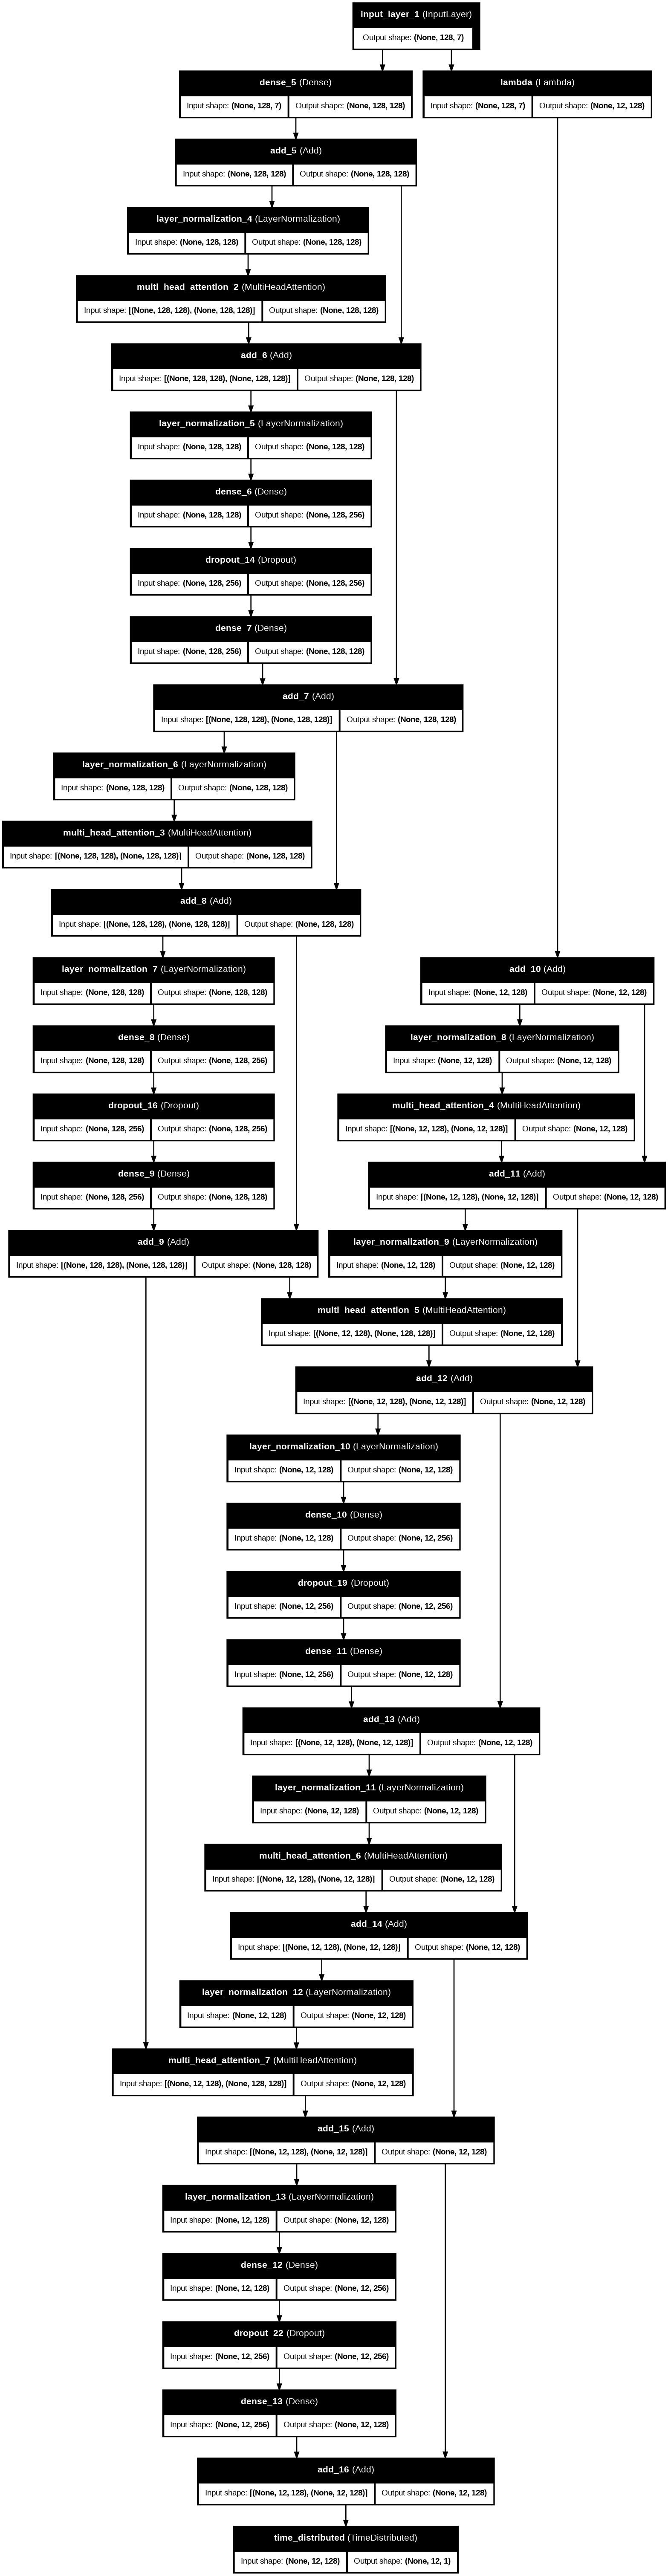

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96)

# نمایش مدل (اختیاری، اگه بخوای توی Jupyter Notebook مستقیم نمایش بده)
from IPython.display import Image
Image(filename='model_architecture.png')

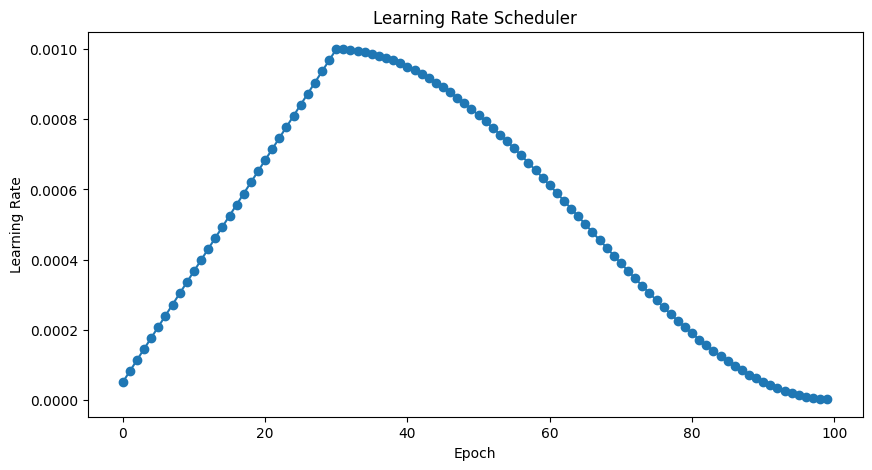


Epoch 1: LearningRateScheduler setting learning rate to 5e-05.
Epoch 1/100
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9047 - mae: 0.1575
Epoch 1 - y_pred[0]:
[[0.20474787]
 [0.21153505]
 [0.20514168]
 [0.20545824]
 [0.21377839]
 [0.21625717]
 [0.22224773]
 [0.23345335]
 [0.2170455 ]
 [0.21058662]
 [0.2085798 ]
 [0.19610377]]
Epoch 1 - y_test[0]:
[0.2337534  0.23312021 0.2327959  0.23274957 0.23265691 0.23304299
 0.23359896 0.23401594 0.23545219 0.23647146 0.2364869  0.23627069]

2634/2634 ━━━━━━━━━━━━━━━━━━━━ 116s 34ms/step - loss: 4.9042 - mae: 0.1575 - val_loss: 1.4092 - val_mae: 0.0115 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.166666666666667e-05.
Epoch 2/100
2633/2634 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9512 - mae: 0.0341
Epoch 2 - y_pred[0]:
[[0.23751959]
 [0.23305872]
 [0.23422799]
 [0.22898106]
 [0.22747952]
 [0.23079121]
 [0.23523149]
 [0.23432943]
 [0.23020768]
 [0.23429263]
 [0.23478761]
 [0.23291007]]
Epoch 2 -

In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow.keras.backend as K
import math
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

class PrintPredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        super(PrintPredictionCallback, self).__init__()
        self.X_test = X_test
        self.y_test = y_test
    
    def on_epoch_end(self, epoch, logs=None):
        # پیش‌بینی برای داده‌های تست
        y_pred = self.model.predict(self.X_test, verbose=0)
        # پرینت y_pred[0]
        print(f"\nEpoch {epoch+1} - y_pred[0]:\n{y_pred[0]}")
        # برای مقایسه، y_test[0] رو هم پرینت می‌کنیم
        print(f"Epoch {epoch+1} - y_test[0]:\n{self.y_test[0]}\n")
        
def get_lr_callback(batch_size=16, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 0.00005, 0.001, 0.000001
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=13,
    restore_best_weights=False,
    start_from_epoch=15,
    verbose=1
)

print_pred_callback = PrintPredictionCallback(X_test, y_test)

y_train = np.expand_dims(y_train, axis=-1)  # از [batch_size, pred_length] به [batch_size, pred_length, 1]
y_val = np.expand_dims(y_val, axis=-1)
epochs = 100
lr_scheduler = get_lr_callback(batch_size=32, mode='cos', epochs=epochs, plot=True)
# آموزش مدل
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler,print_pred_callback]
)

In [22]:
print("Shape of X_train:", X_train.shape)  # باید [num_samples, seq_length, n_features] باشه
print("Shape of y_train:", y_train.shape)  # باید [num_samples, pred_length, 1] باشه
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (84282, 128, 7)
Shape of y_train: (84282, 12, 1, 1)
Shape of X_val: (10535, 128, 7)
Shape of y_val: (10535, 12, 1, 1)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


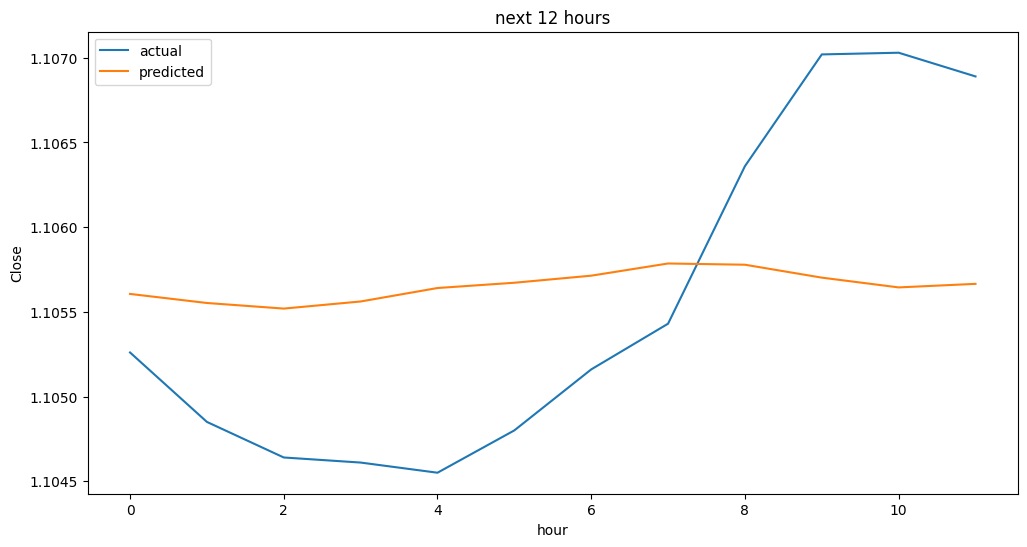

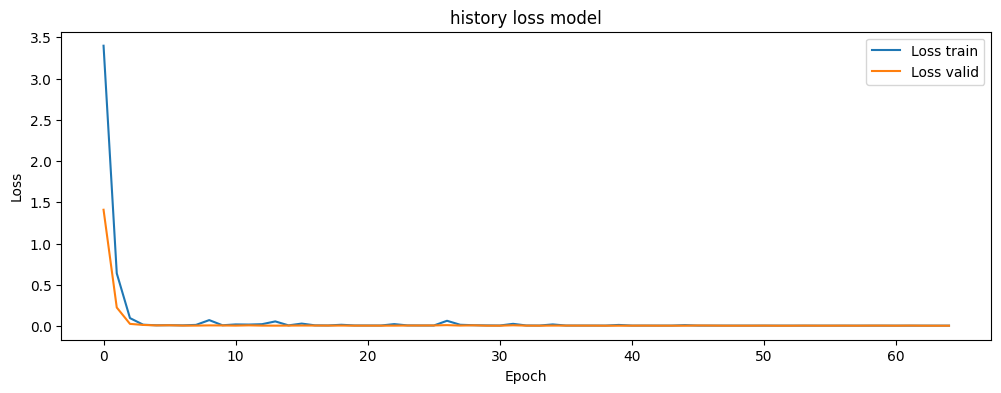

In [17]:

# پیش‌بینی
y_pred = model.predict(X_test)

# معکوس کردن نرمال‌سازی
y_test_inv = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, pred_length))
y_pred_inv = scalers['EURUSD_Close'].inverse_transform(y_pred.reshape(-1, pred_length))

# 4. رسم نتایج
def plot_results(y_test, y_pred, history):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[0], label='actual')
    plt.plot(y_pred[0], label='predicted')
    plt.title('next 12 hours')
    plt.xlabel('hour')
    plt.ylabel('Close')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Loss train')
    plt.plot(history.history['val_loss'], label='Loss valid')
    plt.title('history loss model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 5. اجرا و ذخیره
plot_results(y_test_inv, y_pred_inv, history)


In [18]:
y_test[300]

array([0.22306647, 0.22430195, 0.22339078, 0.22127502, 0.21830986,
       0.21897393, 0.22062639, 0.21871139, 0.21688905, 0.22241784,
       0.22508957, 0.22559921])

In [19]:
y_pred[300]

array([[0.22325012],
       [0.22318242],
       [0.22313417],
       [0.22317456],
       [0.22328413],
       [0.22333503],
       [0.22340828],
       [0.22352326],
       [0.22351535],
       [0.22338708],
       [0.22328685],
       [0.22330692]], dtype=float32)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
predictions = model.predict(X_test)
predictions_average = scalers['EURUSD_Close'].inverse_transform(predictions.reshape(-1, pred_length))
y_test_average = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, pred_length))
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R² Score: {r2:.6f}")

# محاسبه معیارها برای کل داده‌های تست
calculate_metrics(y_test_average, predictions_average, "EURUSD_Close")

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

معیارهای ارزیابی برای EURUSD_Close:
MSE: 0.000006
RMSE: 0.002360
MAE: 0.001594
R² Score: 0.980233


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


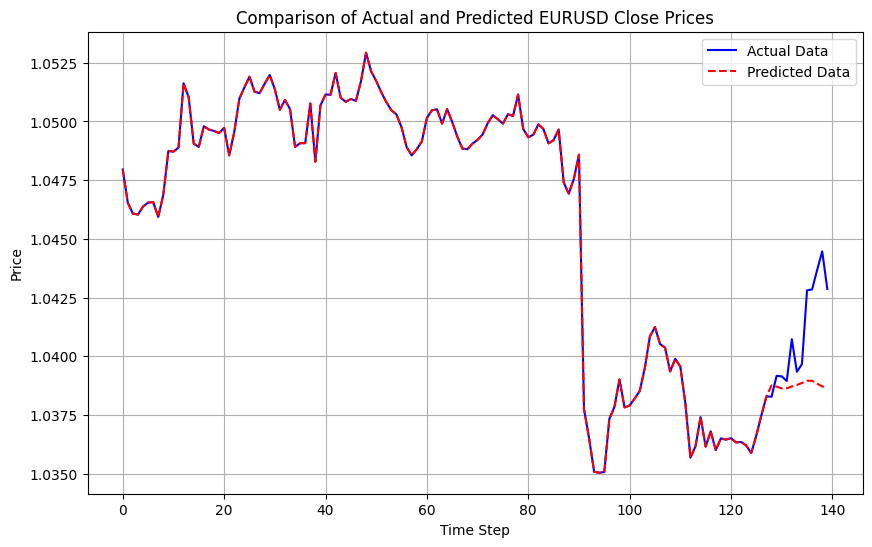

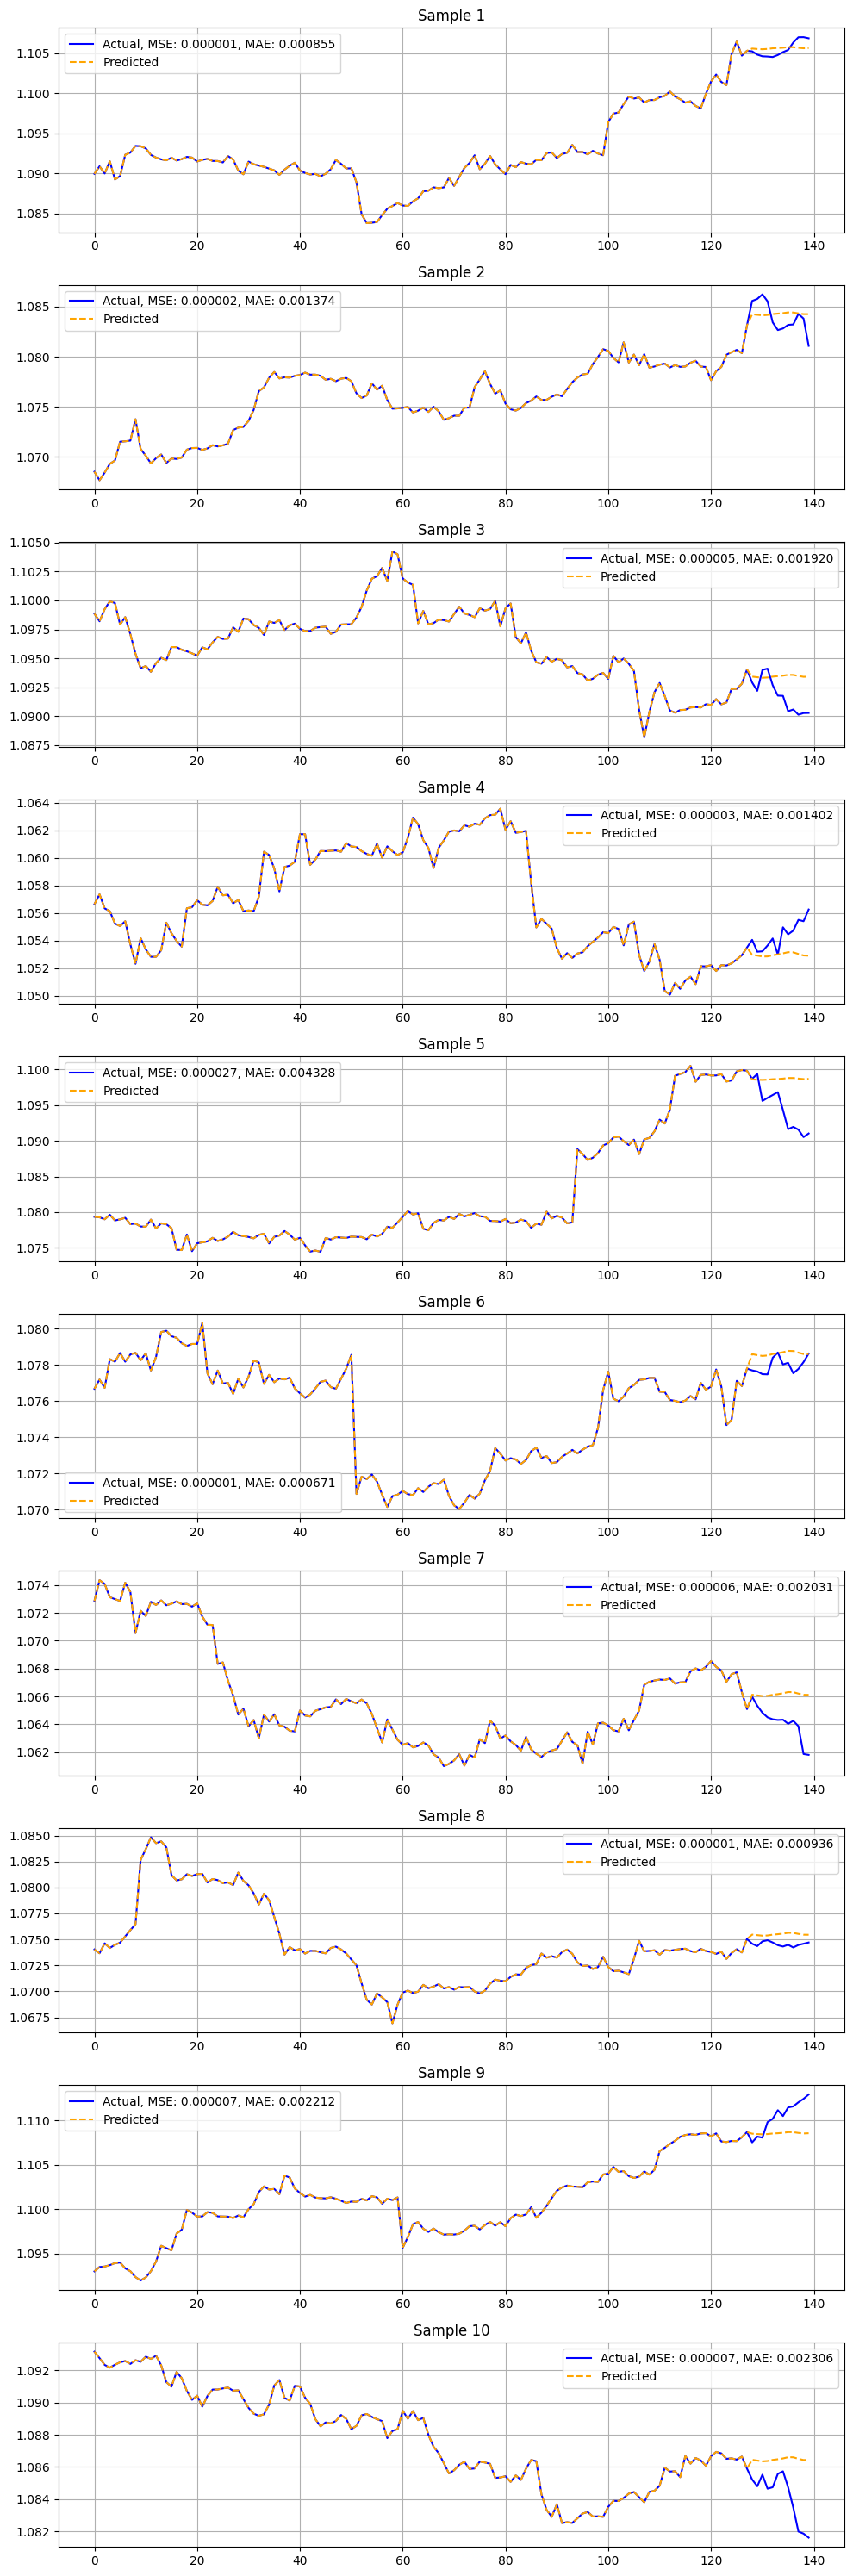

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# معکوس کردن نرمال‌سازی برای برگرداندن به مقیاس اصلی
y_test_inv = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, pred_length))
y_pred_inv = scalers['EURUSD_Close'].inverse_transform(y_pred.reshape(-1, pred_length))

# 4. رسم نمودار کلی (مشابه نمودار اول کد بالا)
# برای این کار، داده‌های ورودی (seq_length آخر) و پیش‌بینی‌ها رو کنار هم می‌ذاریم
last_input = X_test[-1, :, 0]  # آخرین سکانس ورودی (فقط EURUSD_Close)
last_input_inv = scalers['EURUSD_Close'].inverse_transform(last_input.reshape(-1, 1)).flatten()
last_true = y_test_inv[-1]  # آخرین داده واقعی
last_pred = y_pred_inv[-1]  # آخرین پیش‌بینی

# ترکیب داده‌های ورودی و پیش‌بینی/واقعی
concatenated_true = np.concatenate((last_input_inv, last_true))
concatenated_pred = np.concatenate((last_input_inv, last_pred))

# رسم
plt.figure(figsize=(10, 6))
plt.plot(concatenated_true, label='Actual Data', color='blue')
plt.plot(concatenated_pred, label='Predicted Data', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted EURUSD Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 5. رسم چند نمونه (مشابه نمودار دوم کد بالا)
n_samples = 10  # تعداد نمونه‌هایی که می‌خوای رسم کنی
fig, axs = plt.subplots(n_samples, 1, figsize=(10, n_samples * 3))

for i in range(n_samples):
    # انتخاب یه نمونه با فاصله‌های مشخص
    idx = i * (len(X_test) // n_samples)
    sample_input = X_test[idx, :, 0]  # داده ورودی (فقط EURUSD_Close)
    sample_input_inv = scalers['EURUSD_Close'].inverse_transform(sample_input.reshape(-1, 1)).flatten()
    sample_true = y_test_inv[idx]  # داده واقعی
    sample_pred = y_pred_inv[idx]  # پیش‌بینی
    
    # ترکیب داده‌های ورودی و پیش‌بینی/واقعی برای رسم
    sample_true_full = np.concatenate((sample_input_inv, sample_true))
    sample_pred_full = np.concatenate((sample_input_inv, sample_pred))
    
    # محاسبه خطا (MSE)
    mse = mean_squared_error(sample_true, sample_pred)
    mae = mean_absolute_error(sample_true, sample_pred)
    
    # رسم
    axs[i].plot(sample_true_full, label=f'Actual, MSE: {mse:.6f}, MAE: {mae:.6f}', color='blue')
    axs[i].plot(sample_pred_full, label='Predicted', linestyle='--', color='orange')
    axs[i].set_title(f'Sample {i+1}')
    axs[i].legend()
    axs[i].grid(True)

# تنظیم فاصله بین نمودارها
plt.tight_layout()
plt.show()

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
MSE: 0.000006
RMSE: 0.002360
MAE: 0.001594
R² Score: 0.980218


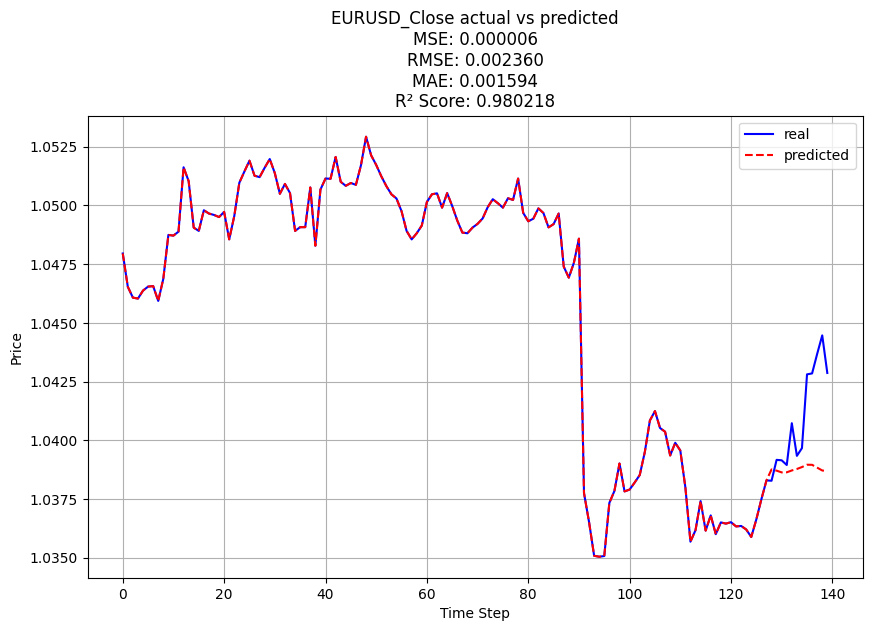

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# فرض می‌کنیم scalers قبلاً تعریف شده
# مثلاً:
# scalers = {}
# scalers['EURUSD_Close'] = MinMaxScaler()
# scalers['EURUSD_Close'].fit(df['EURUSD_Close'].values.reshape(-1, 1))

# فرض می‌کنیم pred_length تعریف شده
pred_length = 12

# پیش‌بینی
y_pred = model.predict(X_test)

# معکوس کردن نرمال‌سازی
y_test_inv = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, 1)).reshape(-1, pred_length)
y_pred_inv = scalers['EURUSD_Close'].inverse_transform(y_pred.reshape(-1, 1)).reshape(-1, pred_length)

# محاسبه معیارهای ارزیابی
# برای محاسبه معیارها، داده‌ها رو به شکل دو‌بعدی درمیاریم
y_test_flat = y_test_inv.reshape(-1)  # [num_samples * pred_length]
y_pred_flat = y_pred_inv.reshape(-1)  # [num_samples * pred_length]

mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_flat, y_pred_flat)
r2 = r2_score(y_test_flat, y_pred_flat)

# چاپ معیارها برای بررسی
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# رسم نمودار برای آخرین نمونه (مشابه نمودار نمونه)
last_input = X_test[-1, :, 0]  # آخرین سکانس ورودی (فقط EURUSD_Close)
last_input_inv = scalers['EURUSD_Close'].inverse_transform(last_input.reshape(-1, 1)).flatten()
last_true = y_test_inv[-1]  # آخرین داده واقعی
last_pred = y_pred_inv[-1]  # آخرین پیش‌بینی

# ترکیب داده‌های ورودی و پیش‌بینی/واقعی
concatenated_true = np.concatenate((last_input_inv, last_true))  # [128 + 12] = [140]
concatenated_pred = np.concatenate((last_input_inv, last_pred))  # [128 + 12] = [140]

# رسم نمودار
plt.figure(figsize=(10, 6))
plt.plot(concatenated_true, label='real', color='blue')
plt.plot(concatenated_pred, label='predicted', color='red', linestyle='--')
plt.title(f'EURUSD_Close actual vs predicted\n'
          f'MSE: {mse:.6f}\n'
          f'RMSE: {rmse:.6f}\n'
          f'MAE: {mae:.6f}\n'
          f'R² Score: {r2:.6f}')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
MSE: 0.000006
RMSE: 0.002360
MAE: 0.001594
R² Score: 0.980218


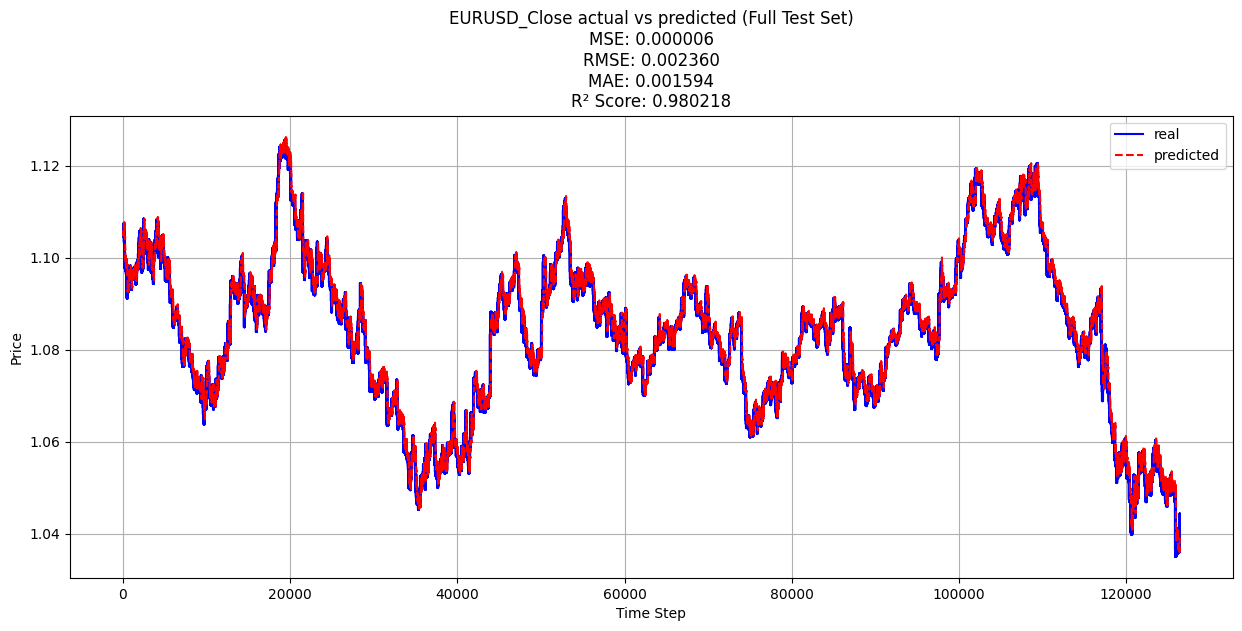

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# فرض می‌کنیم scalers قبلاً تعریف شده
# مثلاً:
# scalers = {}
# scalers['EURUSD_Close'] = MinMaxScaler()
# scalers['EURUSD_Close'].fit(df['EURUSD_Close'].values.reshape(-1, 1))

# فرض می‌کنیم pred_length تعریف شده
pred_length = 12

# پیش‌بینی
y_pred = model.predict(X_test)

# معکوس کردن نرمال‌سازی
y_test_inv = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, 1)).reshape(-1, pred_length)
y_pred_inv = scalers['EURUSD_Close'].inverse_transform(y_pred.reshape(-1, 1)).reshape(-1, pred_length)

# تبدیل داده‌ها به دنباله پیوسته
# y_test_inv و y_pred_inv هر کدوم شکل (10536, 12) دارن
# به شکل (10536 * 12,) تبدیلشون می‌کنیم
y_test_flat = y_test_inv.reshape(-1)  # [10536 * 12] = [126432]
y_pred_flat = y_pred_inv.reshape(-1)  # [10536 * 12] = [126432]

# محاسبه معیارهای ارزیابی
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_flat, y_pred_flat)
r2 = r2_score(y_test_flat, y_pred_flat)

# چاپ معیارها برای بررسی
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# رسم نمودار برای کل داده‌های تست
plt.figure(figsize=(15, 6))
plt.plot(y_test_flat, label='real', color='blue')
plt.plot(y_pred_flat, label='predicted', color='red', linestyle='--')
plt.title(f'EURUSD_Close actual vs predicted (Full Test Set)\n'
          f'MSE: {mse:.6f}\n'
          f'RMSE: {rmse:.6f}\n'
          f'MAE: {mae:.6f}\n'
          f'R² Score: {r2:.6f}')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


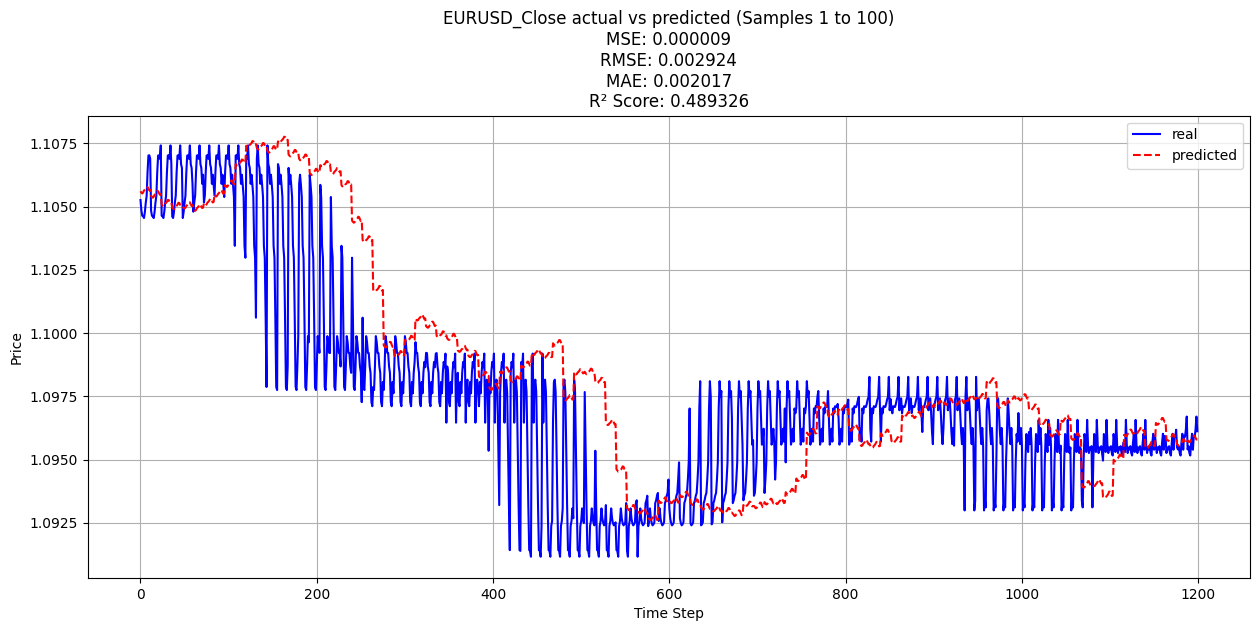

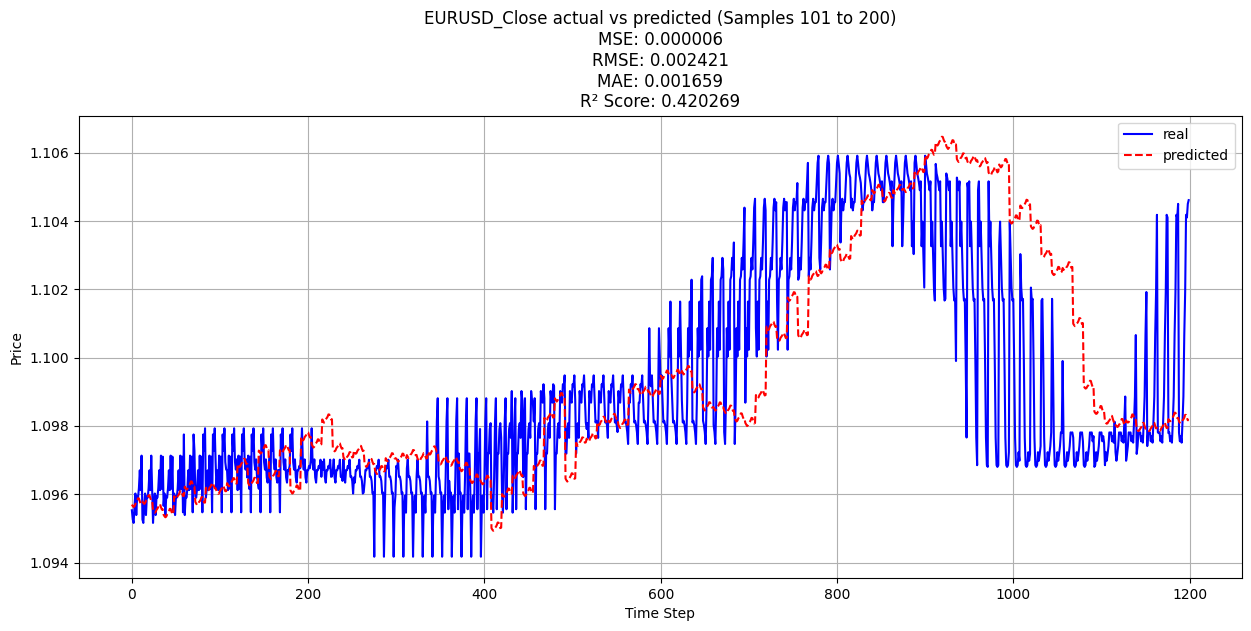

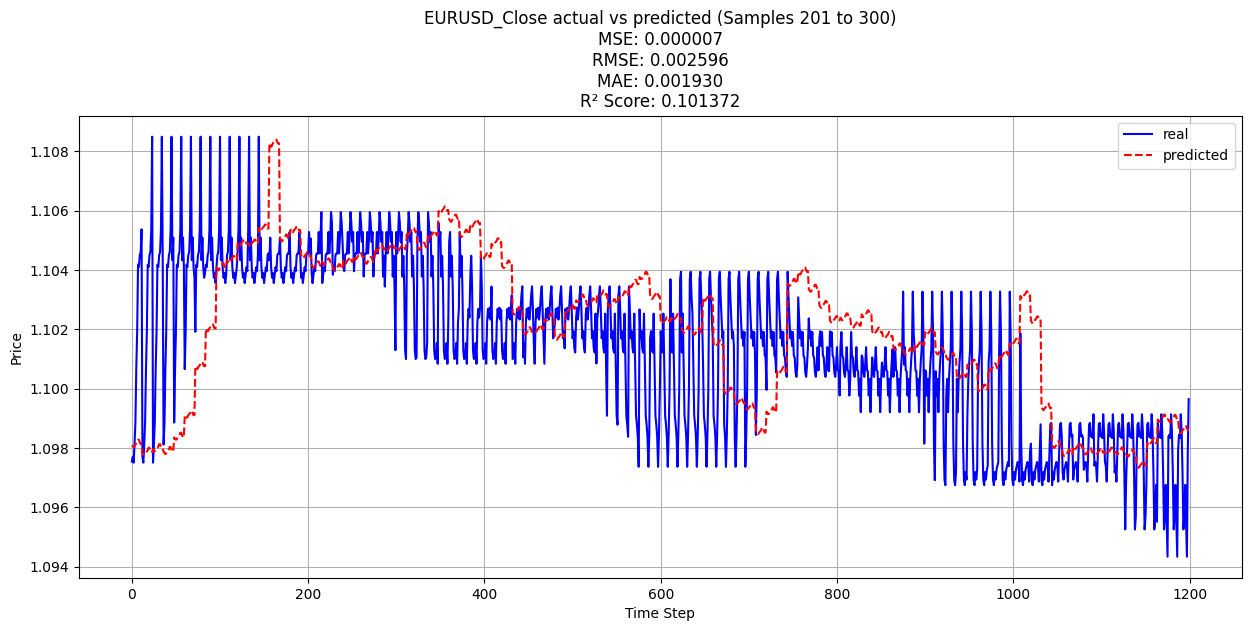

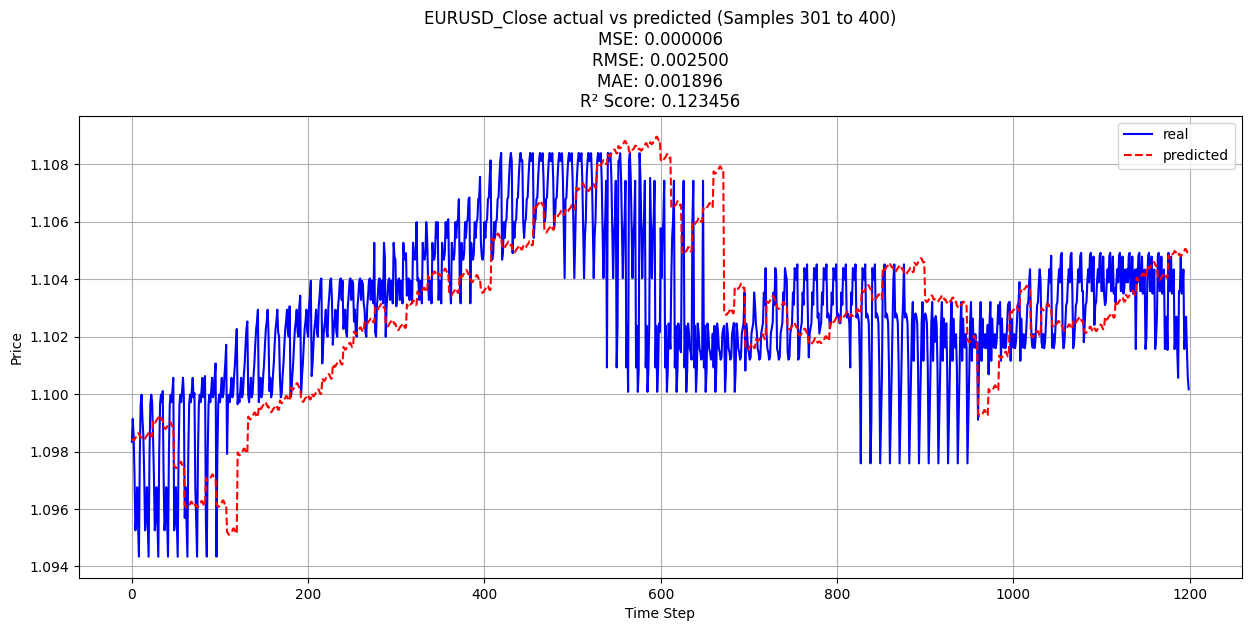

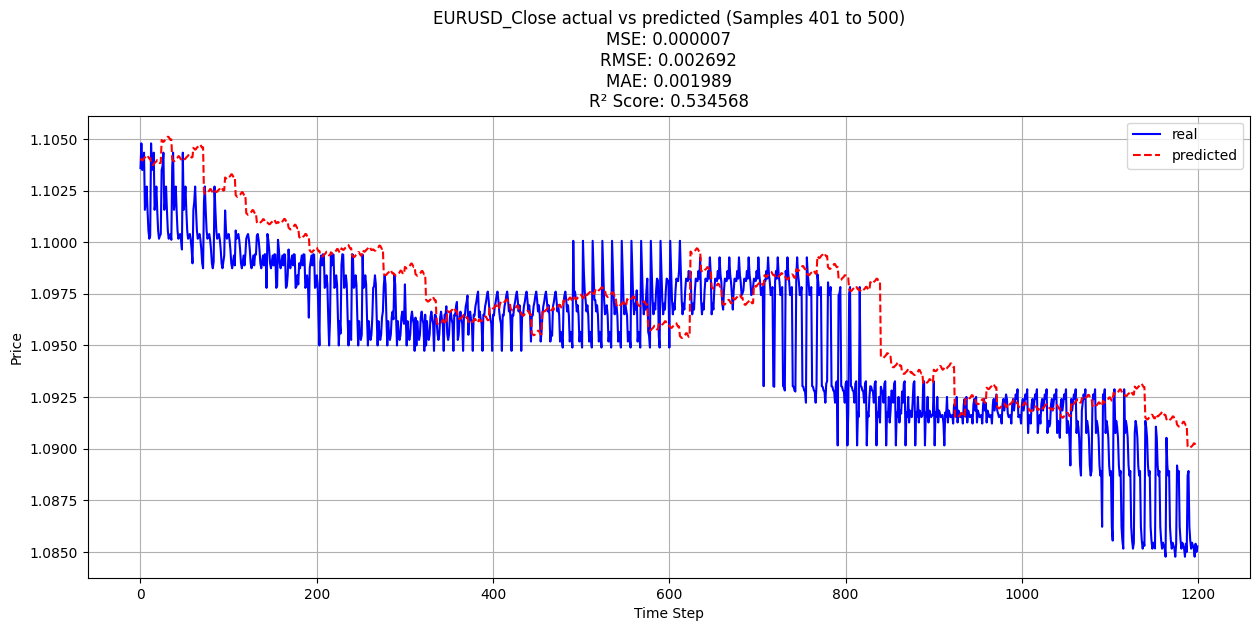

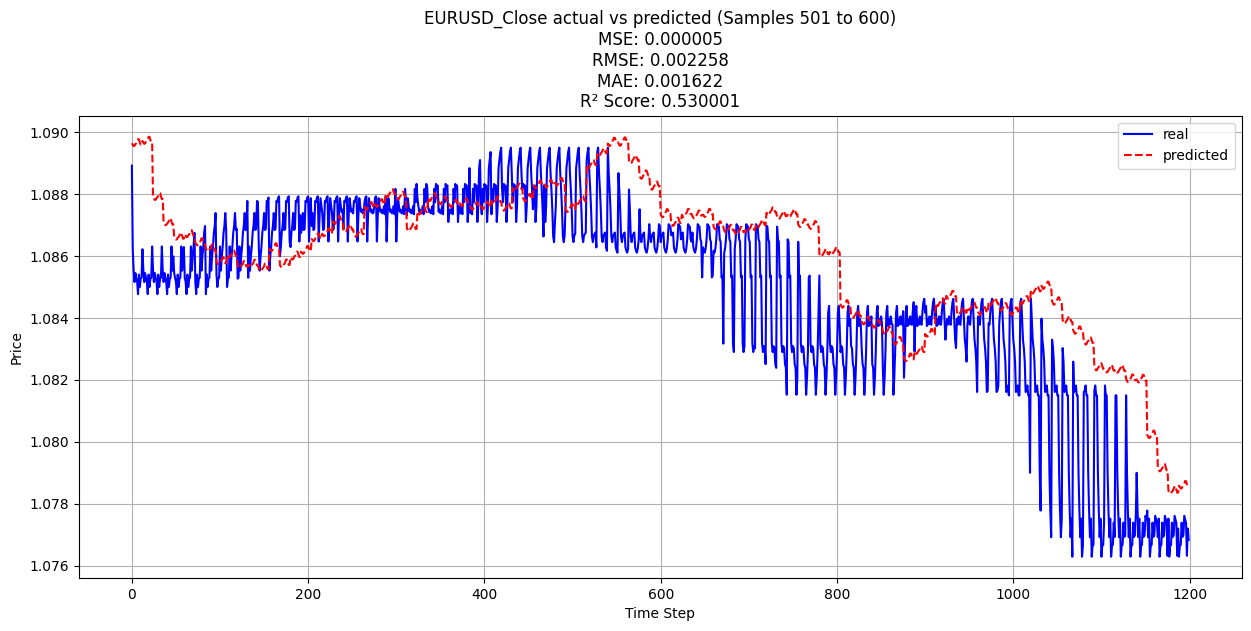

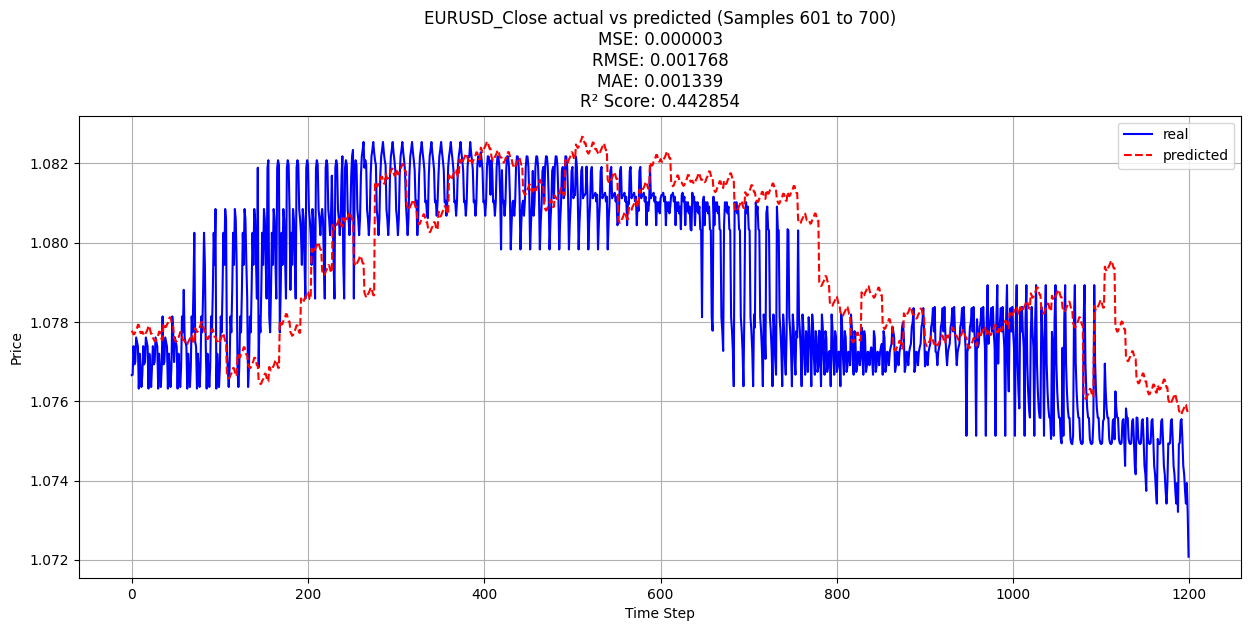

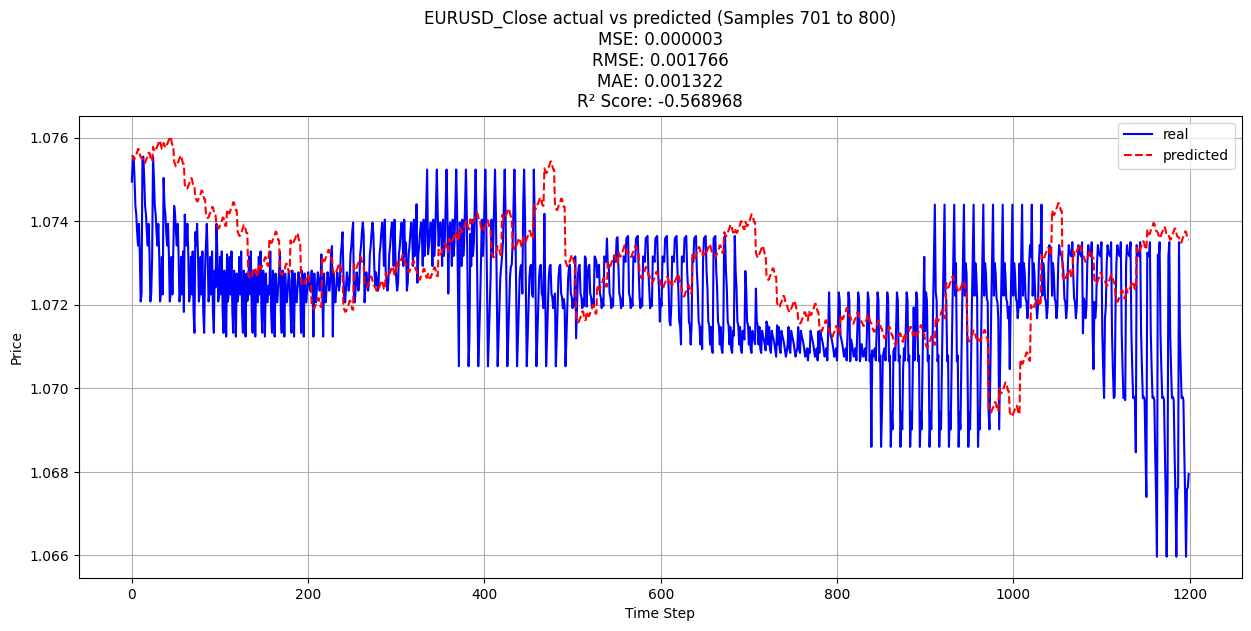

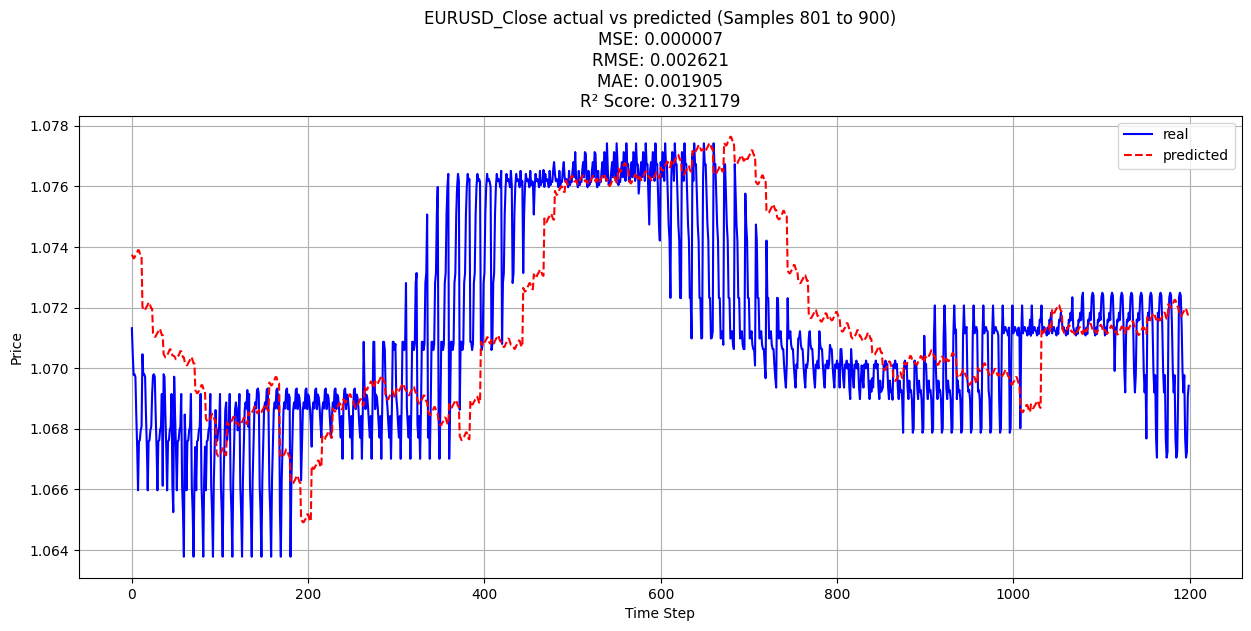

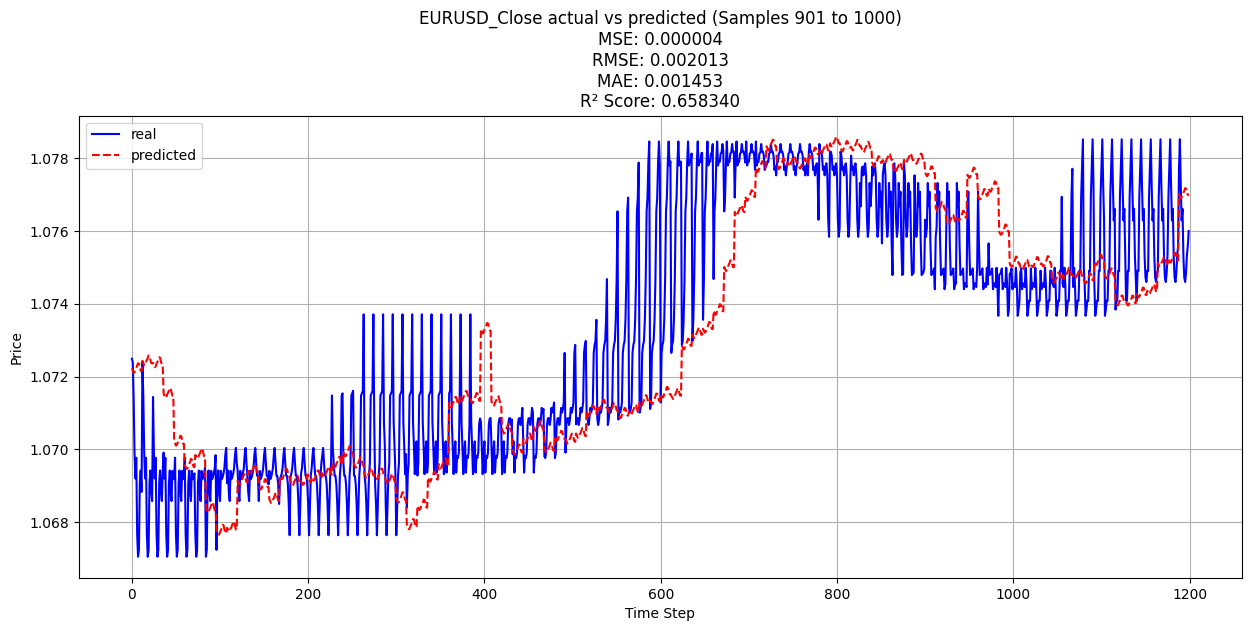

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# فرض می‌کنیم scalers قبلاً تعریف شده
# مثلاً:
# scalers = {}
# scalers['EURUSD_Close'] = MinMaxScaler()
# scalers['EURUSD_Close'].fit(df['EURUSD_Close'].values.reshape(-1, 1))

# فرض می‌کنیم pred_length تعریف شده
pred_length = 12

# پیش‌بینی
y_pred = model.predict(X_test)

# معکوس کردن نرمال‌سازی
y_test_inv = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, 1)).reshape(-1, pred_length)
y_pred_inv = scalers['EURUSD_Close'].inverse_transform(y_pred.reshape(-1, 1)).reshape(-1, pred_length)

# تبدیل داده‌ها به دنباله پیوسته
y_test_flat = y_test_inv.reshape(-1)  # [10536 * 12] = [126432]
y_pred_flat = y_pred_inv.reshape(-1)  # [10536 * 12] = [126432]

# تعداد نمونه‌ها توی هر فیگور
samples_per_figure = 100
timesteps_per_sample = pred_length  # 12 تایم‌استپ برای هر نمونه
timesteps_per_figure = samples_per_figure * timesteps_per_sample  # 100 * 12 = 1200 تایم‌استپ

# تعداد کل فیگورها (ما فقط 10 فیگور می‌خوایم)
num_figures = 10

# تعداد کل تایم‌استپ‌هایی که می‌خوایم پوشش بدیم (برای 10 فیگور)
total_timesteps_to_plot = num_figures * timesteps_per_figure  # 10 * 1200 = 12000 تایم‌استپ

# محدود کردن داده‌ها به 12000 تایم‌استپ اول (برای 10 فیگور)
y_test_flat = y_test_flat[:total_timesteps_to_plot]
y_pred_flat = y_pred_flat[:total_timesteps_to_plot]

# رسم 10 فیگور
for fig_idx in range(num_figures):
    # بازه تایم‌استپ‌ها برای این فیگور
    start_idx = fig_idx * timesteps_per_figure  # مثلاً 0, 1200, 2400, ...
    end_idx = (fig_idx + 1) * timesteps_per_figure  # مثلاً 1200, 2400, 3600, ...
    
    # انتخاب داده‌ها برای این فیگور
    y_test_segment = y_test_flat[start_idx:end_idx]  # [1200]
    y_pred_segment = y_pred_flat[start_idx:end_idx]  # [1200]
    
    # محاسبه معیارهای ارزیابی برای این بخش
    mse = mean_squared_error(y_test_segment, y_pred_segment)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_segment, y_pred_segment)
    r2 = r2_score(y_test_segment, y_pred_segment)
    
    # رسم فیگور
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_segment, label='real', color='blue')
    plt.plot(y_pred_segment, label='predicted', color='red', linestyle='--')
    plt.title(f'EURUSD_Close actual vs predicted (Samples {(fig_idx * samples_per_figure) + 1} to {(fig_idx + 1) * samples_per_figure})\n'
              f'MSE: {mse:.6f}\n'
              f'RMSE: {rmse:.6f}\n'
              f'MAE: {mae:.6f}\n'
              f'R² Score: {r2:.6f}')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
del model